
# Plot Relative Risk

We want to explore the difference in results coming from different confidence thresholds. We will explore the raw data to see where the distribution of FRP is changing on different levels of confidence and see how results change accordingly. 

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpecFromSubplotSpec

from prescribed.plot import template_plots, plot_outcomes, plot_std_diffs
from prescribed.estimate.calculate_estimator import calculate_estimator

# Set the font to be serif, rather than sans
plt.rcParams["font.family"] = "Noto Mono"

# Set the font size to be 12
plt.rcParams["font.size"] = 12

# Set colors for each land type and measurement
colors_land_type = {
    "conifers": "#7fc97f",
    "shrublands": "#beaed4",
    "hardwood": "#fdc086",
    "conifer-hardwood": "#386cb0"
}

colors_measurement = {
    "severity": "Greens",
    "intensity": "Oranges",
}

## Plot severity and intensity classes in our datasets

In [6]:
dnbr_type = "gee_inmediate"
data_path = "/mnt/sherlock/oak/prescribed_data/processed"
dnbr = pd.read_feather(
    os.path.join(data_path, f"dnbr_{dnbr_type}", "dnbr_long.feather")
)
frp = pd.read_feather(os.path.join(data_path, "frp_nominal_conf", "frp_concat.feather"))

# Add land types
land_type = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/land_type/land_type.feather"
)

# Load MTBS to give years to the DNBR data
mtbs = gpd.read_file(
    "/mnt/sherlock/oak/prescribed_data/geoms/mtbs_perims_DD_updated/mtbs_perims_DD.shp"
)
mtbs_ca = mtbs[mtbs.Event_ID.str.startswith("CA")].to_crs(3310)
mtbs_ca["Ig_Date"] = pd.to_datetime(mtbs_ca.Ig_Date)
mtbs_ca["year"] = mtbs_ca.Ig_Date.dt.year

dnbr = dnbr.merge(
    mtbs_ca[["Event_ID", "year"]], left_on="event_id", right_on="Event_ID", how="left"
)
dnbr = dnbr.merge(land_type, on="grid_id", how="left")
frp = frp.merge(land_type, on="grid_id", how="left")


def classify_dnbr(data):
    # Find the DNBR class from the earliest fire per each grid using the
    # DNBR threshold values from Key & Benson (2006):
    conditions = [
        (data.dnbr < 100),
        (data.dnbr >= 100) & (data.dnbr < 270),
        (data.dnbr >= 270) & (data.dnbr < 440),
        (data.dnbr >= 440) & (data.dnbr < 660),
        data.dnbr >= 660,
    ]
    # zero-index to match the low-intensity level to be 1.
    choices = [0, 1, 2, 3, 4]

    # Asigning FRP class to each fire
    data.loc[:, "class_dnbr"] = np.select(conditions, choices, default=np.nan)
    return data


def classify_frp(df):
    conditions = [
        (df.frp > 0) & (df.frp < 100),
        (df.frp >= 100) & (df.frp < 500),
        (df.frp >= 500) & (df.frp < 1000),
        (df.frp >= 1000) & (df.frp < 1500),
        df.frp >= 1500,
    ]
    choices = [1, 2, 3, 4, 5]

    # Asigning FRP class to each fire
    df["class_frp"] = np.select(conditions, choices, default=np.nan)

    return df


raw_dnbr = classify_dnbr(dnbr)
raw_frp = classify_frp(frp)

<Axes: xlabel='year'>

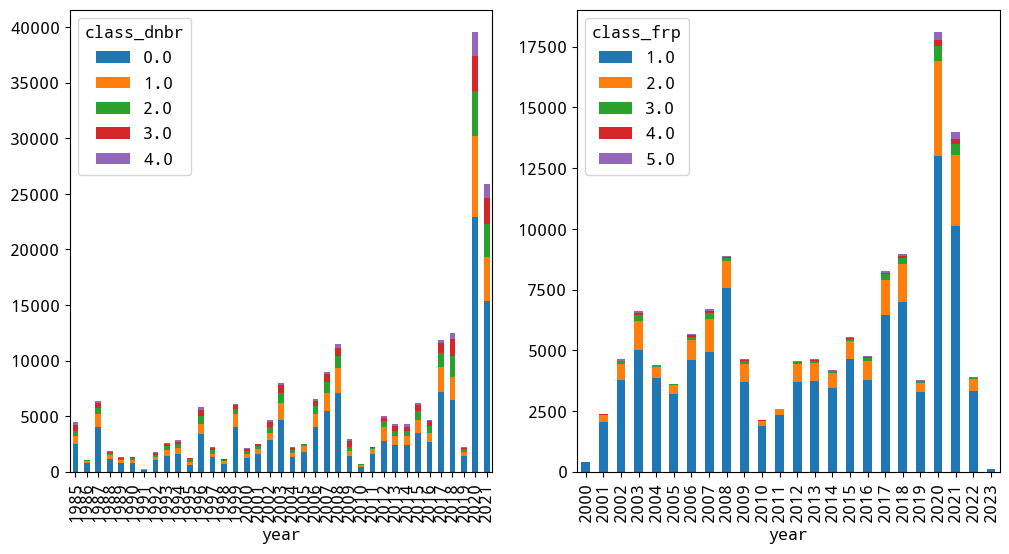

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
dnbr.groupby(["year", "class_dnbr"]).size().unstack().plot(kind="bar", stacked=True, ax=ax[0])
frp.groupby(["year", "class_frp"]).size().unstack().plot(kind="bar", stacked=True, ax=ax[1])

### Plot class distribution

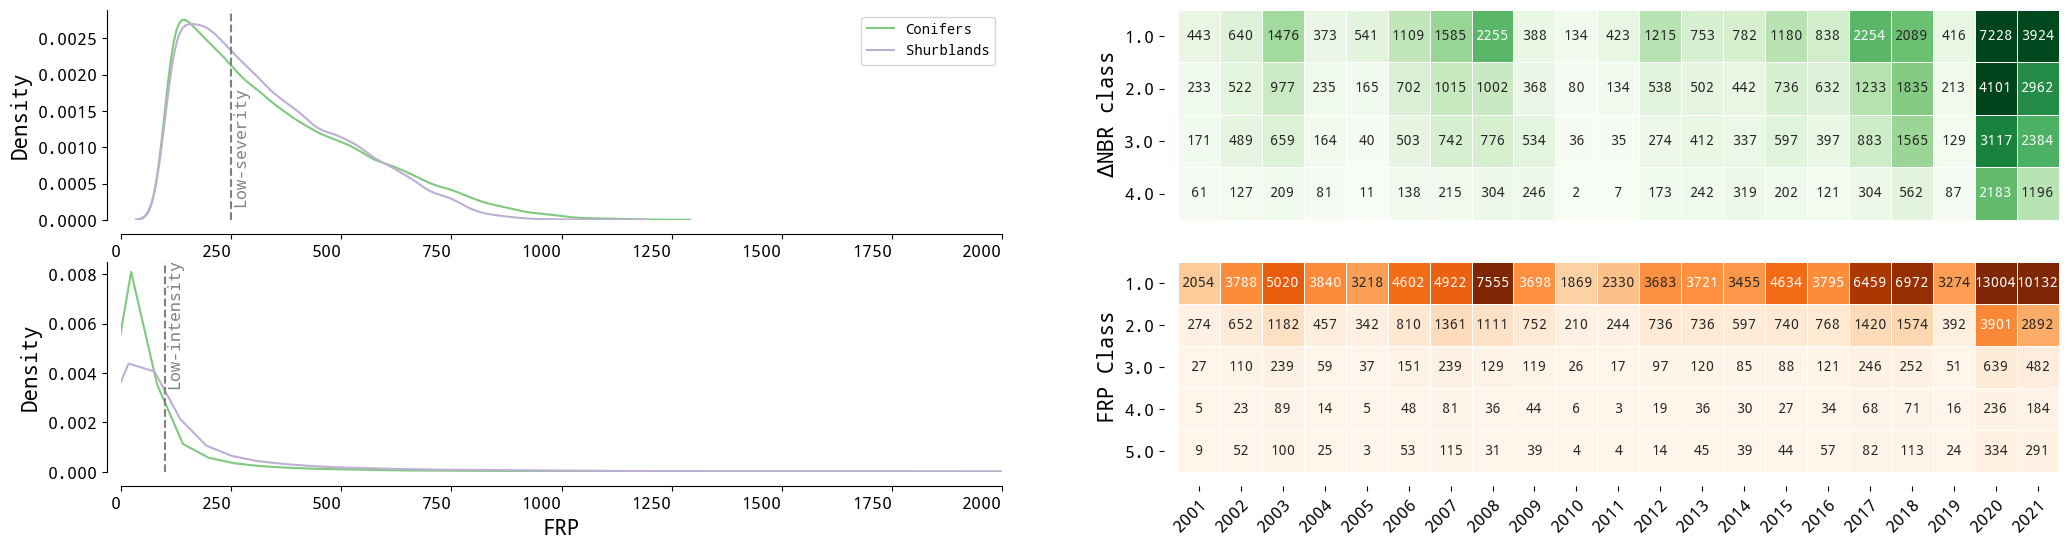

In [8]:
plt.rcParams["font.size"] = 10
fig, ax = plt.subplots(2, 2, figsize=(25, 6))

data = [raw_dnbr[raw_dnbr.class_dnbr > 0], raw_frp]
names_data = ["dnbr", "frp"]

for idx, (data, data_var) in enumerate(zip(data, names_data)):
    # Density plot
    sns.kdeplot(
        data[(data[data_var] > 0 & (data.land_type == 2))][data_var],
        ax=ax[idx, 0],
        color=colors_land_type["conifers"],
        label="Conifers",
    )
    sns.kdeplot(
        data[(data[data_var] > 0) & (data.land_type == 12)][data_var],
        ax=ax[idx, 0],
        color=colors_land_type["shrublands"],
        label="Shurblands",
    )

    template_plots(
        ax=ax[idx, 0],
        ylab="Density",
        xlab=r"$\Delta$NBR" if data_var == "dnbr" else "FRP",
        axis_text=12,
        label_axis=15,
        vert = 250 if data_var == "dnbr" else 100,
        label_vert_pos=(290, 0.001) if data_var == "dnbr" else (140, 0.006),
        label_vert="Low-severity" if data_var == "dnbr" else "Low-intensity",
    )

    ax[idx, 0].set_xlim(0, 2000)

    wide_dnbr = (
        data[(data.year > 2000) & (data.year <= 2021)]
        .pivot_table(
            index=f"class_{data_var}", columns="year", values=data_var, aggfunc="count"
        )
        .fillna(0)
        .astype(int)
    )
    sns.heatmap(
        wide_dnbr,
        annot=True,
        fmt="d",
        cmap=colors_measurement["severity"]
        if data_var == "dnbr"
        else colors_measurement["intensity"],
        ax=ax[idx, 1],
        linewidths=0.5,
        robust=True,
        cbar=False,
    )
    template_plots(
        ax=ax[idx, 1], ylab=r"$\Delta$NBR class" if data_var == "dnbr" else "FRP Class", xlab="", axis_text=12, label_axis=15, rotation_x=45
    )

# Clean up some part of the plot
ax[0, 0].legend()
ax[0, 1].set_xticklabels([])
ax[0, 1].set_xticks([])

plt.savefig("../figs/frp/frp_confidence.png", dpi=300)

## Calculate estimates using RR and ATT for emissions

### Load all data and weights needed to calculate estimates

In [72]:
criteria = "asmd"  # Doesn't matter! We use loss or asmd, both have the same targets
results_dir = "../tyra/mtbs_treatments_results"
results_shrubs = "../tyra/mtbs_treatments_results_inmediate"
results_frp = "../tyra/frp_treatments_results/"

conifers_loss = {
    "weights_dnbr": pd.read_csv(
        f"{results_dir}/dnbr_treatment_conifers/best_model_{criteria}_weights.csv"
    ),
    "weights_frp": pd.read_csv(
        f"{results_dir}/frp_treatment_conifers/best_model_{criteria}_weights.csv"
    ),
    "weights_all": pd.read_csv(
        f"{results_frp}/frp_treatment_conifers/best_model_{criteria}_weights.csv"
    ),
    "std_diffs_dnbr": pd.read_csv(
        f"{results_dir}/dnbr_treatment_conifers/best_model_{criteria}_std_diffs.csv"
    ),
}

shrubs_loss = {
    "weights_dnbr": pd.read_csv(
        f"{results_shrubs}/dnbr_treat_shrubs/best_model_{criteria}_weights.csv"
    ),
    "weights_frp": pd.read_csv(
        f"{results_dir}/frp_treat_shrubs/best_model_{criteria}_weights.csv"
    ),
    "weights_all": pd.read_csv(
        f"{results_frp}/frp_treat_shrubs/best_model_{criteria}_weights.csv"
    ),
    "std_diffs_dnbr": pd.read_csv(
        f"{results_shrubs}/dnbr_treatment_s/best_model_{criteria}_std_diffs.csv"
    ),
}

hardwood_loss = {
    "weights_dnbr": pd.read_csv(
        f"{results_dir}/dnbr_treatment_hardwood/best_model_{criteria}_weights.csv"
    ),
    "weights_frp": pd.read_csv(
        f"{results_dir}/frp_treatment_hardwood/best_model_{criteria}_weights.csv"
    ),
    "weights_all": pd.read_csv(
        f"{results_frp}/frp_treatment_hardwood/best_model_{criteria}_weights.csv"
    ),
}

hc_loss = {
    "weights_dnbr": pd.read_csv(
        f"{results_dir}/dnbr_treatment_coniferhardwood/best_model_{criteria}_weights.csv"
    ),
    "weights_frp": pd.read_csv(
        f"{results_dir}/frp_treatment_coniferhardwood/best_model_{criteria}_weights.csv"
    ),
    "weights_all": pd.read_csv(
        f"{results_frp}/frp_treatment_coniferhardwood/best_model_{criteria}_weights.csv"
    ),
}

# Load MTBS to give years to the DNBR data
mtbs = gpd.read_file(
    "/mnt/sherlock/oak/prescribed_data/geoms/mtbs_perims_DD_updated/mtbs_perims_DD.shp"
)

mtbs_ca = mtbs[mtbs.Event_ID.str.startswith("CA")].to_crs(3310)
mtbs_ca["Ig_Date"] = pd.to_datetime(mtbs_ca.Ig_Date)
mtbs_ca["year"] = mtbs_ca.Ig_Date.dt.year


# Load land types to merge treatments with land type
land_type = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/land_type/land_type.feather"
)

# Load all treatments
wide_treatments = pd.read_feather(
    f"/mnt/sherlock/oak/prescribed_data/processed/wide_treatments_gee/wide_treats_mtbs.feather"
).merge(land_type, on="grid_id", how="left")

wide_treatments_inmediate = pd.read_feather(
    f"/mnt/sherlock/oak/prescribed_data/processed/wide_treatments_gee_inmediate/wide_treats_mtbs.feather"
).merge(land_type, on="grid_id", how="left")

wide_treatments_frp = pd.read_feather(
    f"/mnt/sherlock/oak/prescribed_data/processed/wide_treatments_gee/wide_treats_frp.feather"
).merge(land_type, on="grid_id", how="left")


# Load the dnbr data and merge with MTBS to get years.
dnbr = pd.read_feather(
    f"/mnt/sherlock/oak/prescribed_data/processed/dnbr_gee/dnbr_long.feather"
)

dnbr = dnbr.merge(
    mtbs_ca[["Event_ID", "year"]], left_on="event_id", right_on="Event_ID", how="left"
)

### 1.  Calculate RR for each level of intensity

In [42]:
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")

list_results = []
hc_lists = {
    "All wildfires": [1, 2, 3, 4, 5],
    "High-intensity wildfires": [3, 4, 5],
    "High-severity wildfires": [2, 3, 4],
    "Very High-intensity wildfires": [4, 5],
    "Very High-severity wildfires": [3, 4],
}

for key, high_class in tqdm(hc_lists.items()):

    if key == "All wildfires":
        treat_var = "frp"
        treat_df = wide_treatments
    elif key == "High-intensity wildfires":
        treat_var = "frp"
        treat_df = wide_treatments
    elif key == "High-severity wildfires":
        treat_var = "dnbr"
        treat_df = wide_treatments
    elif key == "Very High-intensity wildfires":
        treat_var = "frp"
        treat_df = wide_treatments
    elif key == "Very High-severity wildfires":
        treat_var = "dnbr"
        treat_df = wide_treatments

    rr_conifer = calculate_estimator(
        treatments=treat_df[treat_df.land_type == 2],
        weights=conifers_loss[f"weights_{treat_var}"],
        outcomes="rr",
        focal_years=range(2008, 2022),
        outcome_var=None,
        low_treatment_class={treat_var if key != "All wildfires" else "frp": 1},
        pooling=True,
        high_class=high_class,
        cluster_var="year",
        formula="att ~ lag",
        freq_weights="control_count",
        max_lags=14,
        rr=True,
    )
    rr_conifer["high_class"] = key
    rr_conifer["land_type"] = "conifers"
    list_results.append(rr_conifer)

    # rr_hardwood = calculate_estimator(
    #     treatments=treat_df[treat_df.land_type == 8],
    #     weights=hardwood_loss[f"weights_{treat_var}"],
    #     outcomes="rr",
    #     focal_years=range(2008, 2022),
    #     outcome_var=None,
    #     low_treatment_class={treat_var if key != "All fires" else "frp": 1},
    #     pooling=True,
    #     high_class=high_class,
    #     cluster_var="year",
    #     formula="att ~ lag",
    #     freq_weights="control_count",
    #     max_lags=12,
    #     rr=True,
    # )
    # rr_hardwood["high_class"] = key
    # rr_hardwood["land_type"] = "hardwood"
    # list_results.append(rr_hardwood)

    # try:
    #     rr_hc = calculate_estimator(
    #         treatments=treat_df[treat_df.land_type == 3],
    #         weights=hc_loss[f"weights_{treat_var}"],
    #         outcomes="rr",
    #         focal_years=range(2008, 2022),
    #         outcome_var=None,
    #         low_treatment_class={treat_var if key != "All fires" else "frp": 1},
    #         pooling=True,
    #         high_class=high_class,
    #         cluster_var="year",
    #         formula="att ~ lag",
    #         freq_weights="control_count",
    #         max_lags=12,
    #         rr=True,
    #     )
    #     rr_hc["high_class"] = key
    #     rr_hc["land_type"] = "conifer-hardwood"
    #     list_results.append(rr_hc)
    
    # except Exception as e:
    #     pass
    #     print(e)
    #     rr_shrubs = None

    try:
        # Do the same for shrubs
        if key == "High-intensity fires":
            treat_df = wide_treatments_inmediate

        rr_shrubs = calculate_estimator(
            treatments=treat_df[treat_df.land_type == 12],
            weights=shrubs_loss[f"weights_{treat_var}"],
            outcomes="rr",
            focal_years=range(2008, 2022),
            outcome_var=None,
            low_treatment_class={treat_var if key != "All wildfires" else "frp": 1},
            pooling=True,
            high_class=high_class,
            cluster_var="year",
            formula="att ~ lag",
            freq_weights="control_count",
            max_lags=14,
            rr=True,    
        )
        rr_shrubs["high_class"] = key
        rr_shrubs["land_type"] = "shrublands"

    except Exception as e:
        pass
        print(e)
        rr_shrubs = None

    list_results.append(rr_shrubs)

Calculating estimator per focal year...: 100%|██████████| 14/14 [00:36<00:00,  2.62s/it]
Error calculating estimator for focal year 2021: cannot set a frame with no defined index and a scalar
Calculating estimator per focal year...: 100%|██████████| 14/14 [00:37<00:00,  2.66s/it]
Error calculating estimator for focal year 2021: cannot set a frame with no defined index and a scalar
100%|██████████| 5/5 [07:35<00:00, 91.09s/it]


### 2. Calculate ATT for emissions

In [43]:
# Emissions FINN
emissions_all = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/emissions_finn/finn_GEOSCHEM_mean.feather"
)
emissions_all["year"] = emissions_all["time"].dt.year

################################################################################
########## ESTIMATE EFFECTS OF EMISSIONS FOR CONIFERS AND SHRUBS ###############
################################################################################
df_emissions = calculate_estimator(
    treatments=wide_treatments_frp[wide_treatments_frp.land_type == 2],
    weights=conifers_loss["weights_dnbr"],
    outcomes=emissions_all,
    focal_years=range(2012, 2022),
    outcome_var="PM25",
    low_treatment_class={"dnbr": 1},
    scale=0.001,  # Kg to T
    pooling=True,
    cluster_var="year",
    formula="att ~ lag",
    max_lags=14,
    
)

df_emissions_shurbs = calculate_estimator(
    treatments=wide_treatments_inmediate[wide_treatments_inmediate.land_type == 12],
    #treatments=wide_treatments_frp[wide_treatments_frp.land_type == 12],
    weights=shrubs_loss["weights_dnbr"],
    outcomes=emissions_all,
    focal_years=range(2012, 2022),
    outcome_var="PM25",
    low_treatment_class={"dnbr": 1},
    scale=0.001,  # Kg to T
    pooling=True,
    cluster_var="year",
    formula="att ~ lag",
    max_lags=14,
)

Calculating estimator per focal year...: 100%|██████████| 10/10 [00:00<00:00, 28.81it/s]


idx: 0, idx_: 0, hc: All wildfires, lt: conifers
idx: 0, idx_: 1, hc: All wildfires, lt: shrublands
idx: 1, idx_: 0, hc: High-intensity wildfires, lt: conifers
idx: 1, idx_: 1, hc: High-intensity wildfires, lt: shrublands
idx: 2, idx_: 0, hc: High-severity wildfires, lt: conifers
idx: 2, idx_: 1, hc: High-severity wildfires, lt: shrublands


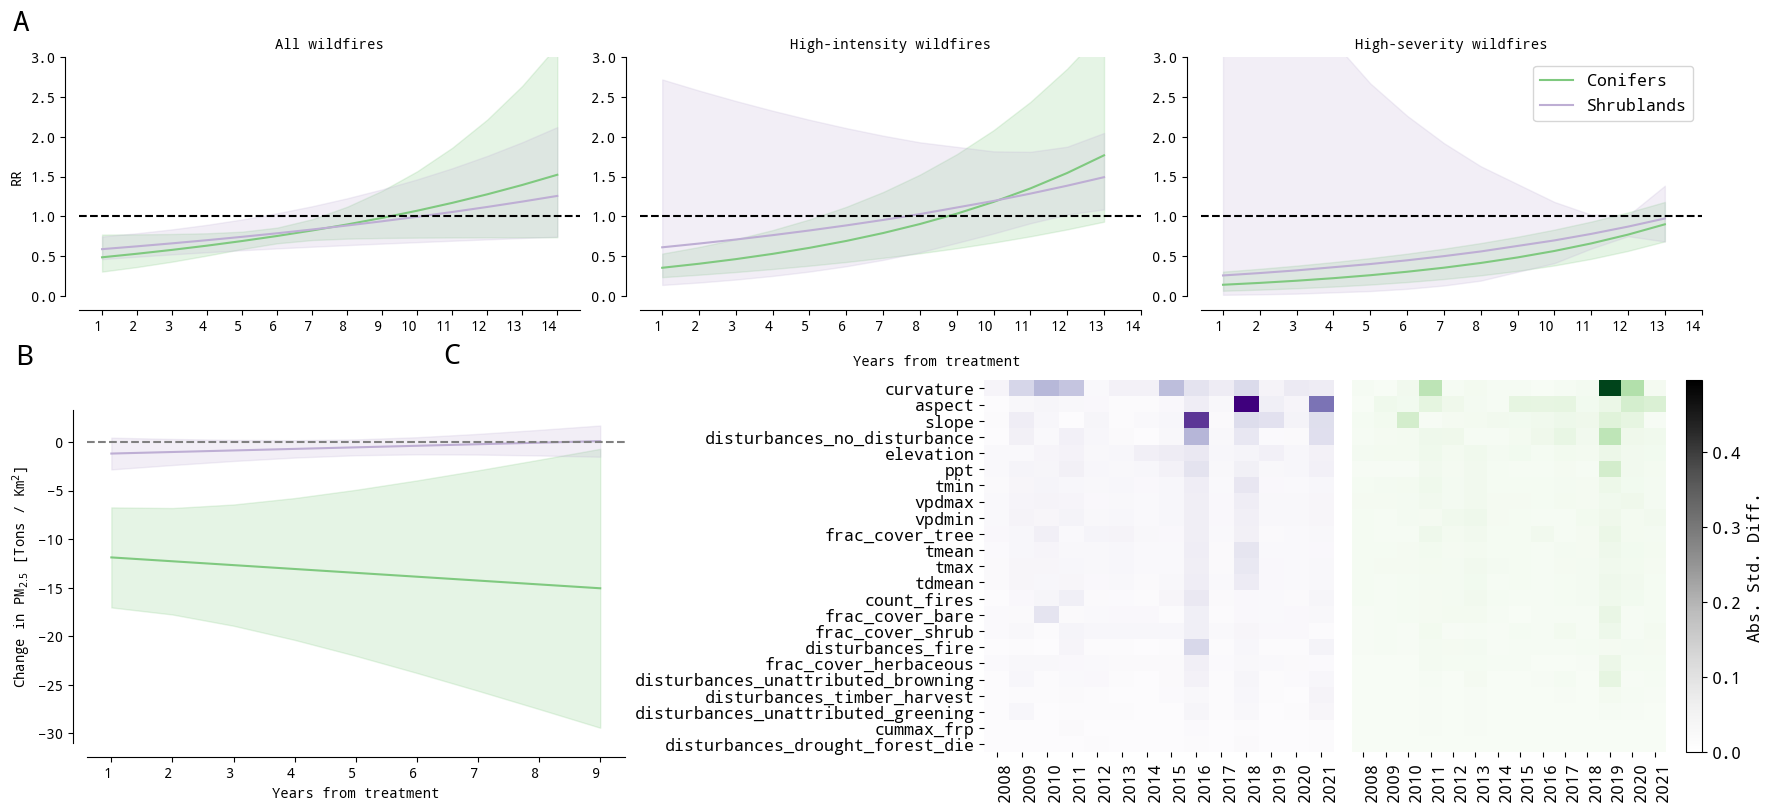

In [81]:

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Concatenate list with all results to plot
rrs = pd.concat(list_results)
rrs.sort_values("year", inplace=True)

# Plot coefs and CIs for the different high classes and land types
fig = plt.figure(figsize=(17, 8),  layout="compressed")
spec = fig.add_gridspec(2, 3)

subspec = GridSpecFromSubplotSpec(1, 3, subplot_spec=spec[0, :])

################################################################################
######################### PLOT STANDARIZED DIFFERENCES #########################
################################################################################

rrs = rrs[rrs.land_type.isin(["conifers", "shrublands"])]

for idx, hc in enumerate({k: hc_lists[k] for k in ['All wildfires', 'High-intensity wildfires', 'High-severity wildfires']}):
    ax = fig.add_subplot(subspec[0, idx])
    for idx_, lt in enumerate(rrs.land_type.unique()):
        print(f"idx: {idx}, idx_: {idx_}, hc: {hc}, lt: {lt}")
        data = rrs[(rrs.high_class == hc) & (rrs.land_type == lt)]
        data.plot(
            x="year", 
            y="coef", 
            ax=ax,
            label=lt.capitalize(),
            legend=True if idx == 2 else False,
            color=colors_land_type[lt]
        )

        ax.fill_between(
            data.year,
            data.low_ci,
            data.high_ci,
            alpha=0.2,
            color=colors_land_type[lt],
        )

    ax.axhline(1, color="black", linestyle="--")
    ax.set_title(f"{hc.capitalize()}", fontsize=10)

    # Chage x-axis ticks to go from 1 to 9
    ax.set_xticks(range(1, 15))
    ax.set_xticklabels(range(1, 15))

    ax.set_ylim([0, 2])
    ax.set_yticks(np.arange(0, 3.1, 0.5))
    ax.set_yticklabels(np.arange(0, 3.1, 0.5))

    # Formatting
    template_plots(
        ax=ax,
        xlab="",
        ylab="RR" if idx == 0 else "",
        axis_text=10,
        label_axis=10,
        label="A" if idx == 0 else None,
        label_vert_pos=(2008, 1.1),
    )

fig.text(0.55, 0.55, "Years from treatment ", ha="center", fontsize=10)

################################################################################
######################### PLOT STANDARIZED DIFFERENCES #########################
################################################################################
ax = fig.add_subplot(spec[1, 0])

# Add space between the plots
plt.subplots_adjust(hspace=0.5)

plot_outcomes(
    df_conifer=df_emissions,
    df_shrub=df_emissions_shurbs,
    legend=False,
    var_interest="att",
    axes_names=(
        "Years from treatment",
        r"Change in PM$_{2.5}$ [Tons / Km$^{2}$]",
    ),
    ax=ax,
    colors=[colors_land_type["conifers"], colors_land_type["shrublands"]],
    pooled=True,
    axis_text=10,
    label_axis=10,
    label="B"
)

################################################################################
######################### PLOT STANDARIZED DIFFERENCES #########################
################################################################################

subspec = GridSpecFromSubplotSpec(1, 2, subplot_spec=spec[1, 1:3], wspace=0.01)

# Define mins and max for the two plots
v_max = np.max(
    [
        shrubs_loss["std_diffs_dnbr"]["std_weighted_asmd"].max(),
        conifers_loss["std_diffs_dnbr"]["std_weighted_asmd"].max(),
    ]
)

v_min = np.min(
    [
        shrubs_loss["std_diffs_dnbr"]["std_weighted_asmd"].min(),
        conifers_loss["std_diffs_dnbr"]["std_weighted_asmd"].min(),
    ]
)

ax = fig.add_subplot(subspec[0, 0])
im1 = plot_std_diffs(
    std_diffs_df=shrubs_loss["std_diffs_dnbr"],
    palette="Purples",
    ax=ax,
    labels_y=True,
    draw_cbar=False,
    label="C",
    rotation_x=90,
    drop_vars=["Intercept", "land_type"],
)

ax = fig.add_subplot(subspec[0, 1])
im2 = plot_std_diffs(
    std_diffs_df=conifers_loss["std_diffs_dnbr"],
    palette="Greens",
    labels_y=False,
    draw_cbar=False,
    rotation_x=90,
    drop_vars=["Intercept", "land_type"],
    ax=ax,
)

# Add a shared colorbar between the two plots im1 and im2
# Create a custom colorbar with a different colormap
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)

fig.colorbar(
    ScalarMappable(norm=Normalize(vmin=v_min, vmax=v_max), cmap="Greys"),
    cax=cax,
    orientation="vertical",
    label="Abs. Std. Diff.",
)


In [82]:
v_max = np.max(
    [
        shrubs_loss["std_diffs_dnbr"]["std_weighted_asmd"].max(),
        conifers_loss["std_diffs_dnbr"]["std_weighted_asmd"].max(),
    ]
)

v_min = np.min(
    [
        shrubs_loss["std_diffs_dnbr"]["std_weighted_asmd"].min(),
        conifers_loss["std_diffs_dnbr"]["std_weighted_asmd"].min(),
    ]
)


In [86]:
conifers_loss["std_diffs_dnbr"]["std_weighted_asmd"].max()

0.2438382